# 2022-03-02 Polynomial Interpolation

## Last time

* Reflection on algorithm choices
* Low-rank structure
* Example of interacting galaxies

## Today

* Interpolation using polynomials
* Structure of generalized Vandermonde matrices
* Conditioning of interpolation and Vandermonde matrices
* Choice of points and choice of basis

In [2]:
using LinearAlgebra
using Plots
default(linewidth=4, legendfontsize=12)

function vander(x, k=nothing)
    if isnothing(k)
        k = length(x)
    end
    m = length(x)
    V = ones(m, k)
    for j in 2:k
        V[:, j] = V[:, j-1] .* x
    end
    V
end

function peanut()
    theta = LinRange(0, 2*pi, 50)
    r = 1 .+ .4*sin.(3*theta) + .6*sin.(2*theta)
    r' .* [cos.(theta) sin.(theta)]'
end

function circle()
    theta = LinRange(0, 2*pi, 50)
    [cos.(theta) sin.(theta)]'
end

function Aplot(A)
    "Plot a transformation from X to Y"
    X = peanut()
    Y = A * X
    p = scatter(X[1,:], X[2,:], label="in")
    scatter!(p, Y[1,:], Y[2,:], label="out")
    X = circle()
    Y = A * X
    q = scatter(X[1,:], X[2,:], label="in")
    scatter!(q, Y[1,:], Y[2,:], label="out")
    plot(p, q, layout=2, aspect_ratio=:equal)
end

Aplot (generic function with 1 method)

# What is interpolation?

Given data $(x_i, y_i)$, find a (smooth?) function $f(x)$ such that $f(x_i) = y_i$.

## Data in

* direct field observations/measurement of a physical or social system
* numerically processed observations, perhaps by applying physical principles
* output from an expensive "exact" numerical computation
* output from an approximate numerical computation

## Function out

* Polynomials
* Piecewise polynomials (includes nearest-neighbor)
* Powers and exponentials
* Trigonometric functions (sine and cosine)
* Neural networks

Interpolation fits the data exactly!

# Polynomial interpolation

We've seen how we can fit a polynomial using Vandermonde matrices, one column per basis function and one row per observation.

$$ \underbrace{\Bigg[ 1 \Bigg| x \Bigg| x^2 \Bigg| x^3 \Bigg]}_{A \in \mathbb R^{m\times n}} \Bigg[ \mathbf p \Bigg] = \Bigg[ \mathbf y \Bigg] $$

It's possible to find a unique polynomial $\mathbf p$ when which of the following are true?
1. $m \le n$
2. $m = n$
3. $m \ge n$

# Polynomial interpolation with a Vandermonde matrix

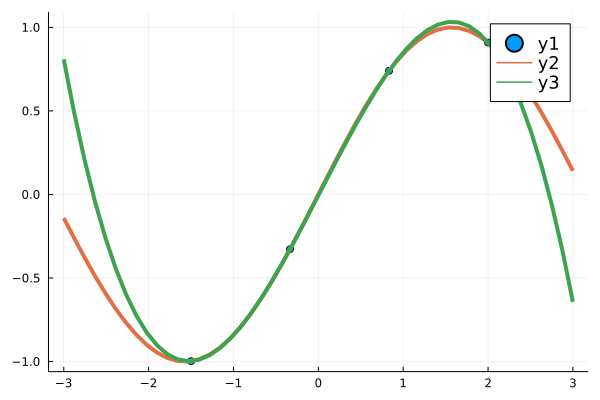

In [3]:
x = LinRange(-1.5, 2, 4)
y = sin.(x)
A = vander(x)
p = A \ y

scatter(x, y)
s = LinRange(-3, 3, 50)
plot!(s, [sin.(s) vander(s, length(p)) * p])

## Vandermonde matrices can be ill-conditioned

In [4]:
A = vander(LinRange(-1, 1, 30))
cond(A)

1.838577055392608e13

1. It's because of the points $x$?
2. It's because of the basis functions $\{ 1, x, x^2, x^3, \dotsc \}$?

### Lagrange Interpolating Polynomials

Suppose we are given function values $y_0, \dotsc, y_m$ at the distinct points $x_0, \dotsc, x_m$ and we would like to build a polynomial of degree $m$ that goes through all these points.  This explicit construction is attributed to Lagrange (though he was not first):

$$ p(t) = \sum_{i=0}^m y_i \prod_{j \ne i} \frac{t - x_j}{x_i - x_j} $$

* What is the degree of this polynomial?
* Why is $p(x_i) = y_i$?
* How expensive (in terms of $m$) is it to evaluate $p(x)$?
* How expensive (in terms of $m$) is it to convert to standard form $p(x) = \sum_{i=0}^m a_i x^i$?
* Can we easily evaluate the derivative $p'(x)$?
* What can go wrong?  Is this formulation numerically stable?

## Lagrange interpolation in code

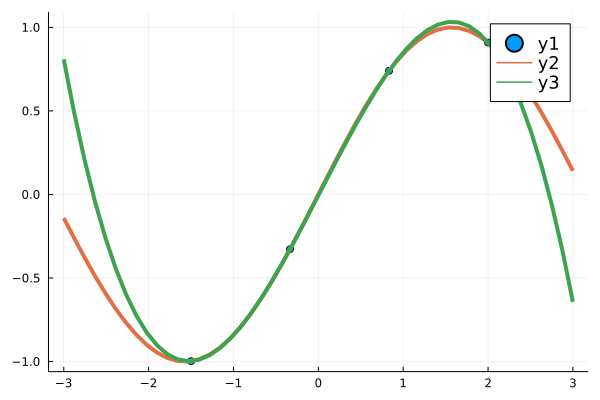

In [5]:
function lagrange(x, y)
    function p(t)
        m = length(x)
        w = 0
        for (i, yi) in enumerate(y)
            w += yi * (prod(t .- x[1:i-1]) * prod(t .- x[i+1:end])
                / (prod(x[i] .- x[1:i-1]) * prod(x[i] .- x[i+1:end])))
        end
        w
    end
    return p
end
p = lagrange(x, y)
scatter(x, y)
plot!(s, [sin.(s) p.(s)])

In [9]:
# Notice how important this is
prod(Float64[])

1.0

# We don't have `cond(lagrange(x, y))`

It's just a function and we know
$$ \kappa(f) = \lvert f' \rvert \frac{|x|}{|f|} $$
but this definition depends on the input $x$ and it's difficult to explore that space.

* We also don't have an easy way to evaluate derivatives.

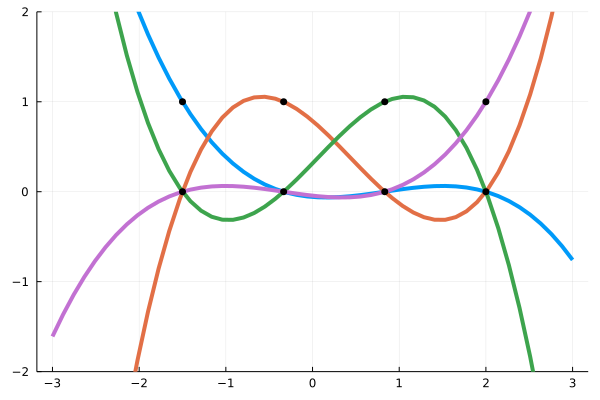

In [16]:
B = vander(s, 4) / vander(x)
plot(s, B)
scatter!(x, [zero.(x) one.(x)], color=:black, legend=:none, ylims=(-2, 2))

# Newton polynomials

Newton polynomials are polynomials

$$ n_k(x) = \prod_{i=0}^{k-1} (x - x_i) $$

This gives the Vandermonde interpolation problem is

$$ \Big[ 1 \Big| (x - x_0) \Big| (x - x_0)(x - x_1) \Big| \dotsb \Big] \Big[ p \Big] = \Big[ y \Big] $$

* How does the Vandermonde procedure change if we replace $x^k$ with $n_k(x)$?
* Does the matrix have recognizable structure?

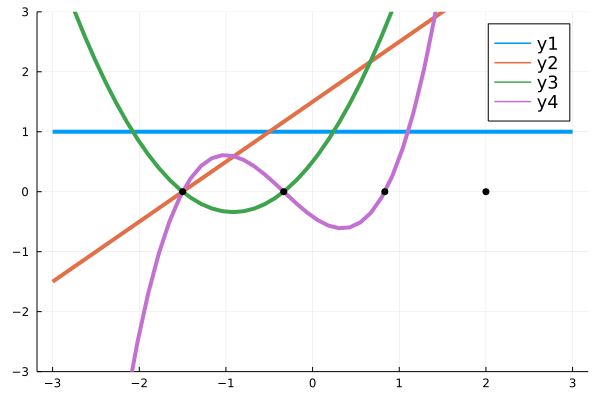

In [20]:
function vander_newton(x, abscissa=nothing)
    if isnothing(abscissa)
        abscissa = x
    end
    n = length(abscissa)
    A = ones(length(x), n)
    for i in 2:n
        A[:,i] = A[:,i-1] .* (x .- abscissa[i-1])
    end
    A
end

A = vander_newton(s, x)
plot(s, A, ylims=(-3, 3))
scatter!(x, [zero.(x)], color=:black, label=nothing)

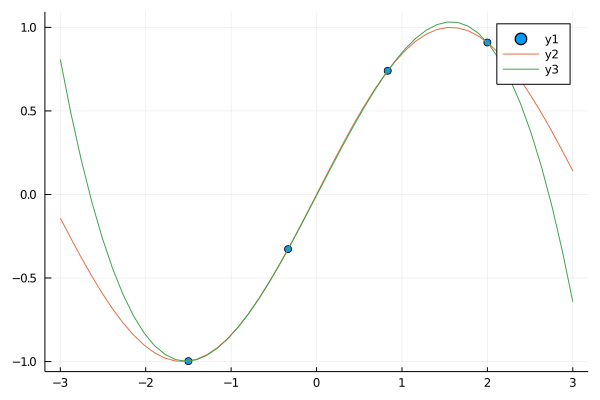

In [107]:
p = vander_newton(x, x) \ y
scatter(x, y)
plot!(s, [sin.(s), vander_newton(s, x) * p])

# Newton Vandermonde matrix structure

* How much does it cost to solve with a general $n\times n$ dense matrix?
  1. $O(n \log n)$
  2. $O(n^2)$
  3. $O(n^3)$

In [58]:
vander_newton(LinRange(-1, 1, 5))

5×5 Array{Float64,2}:
 1.0  0.0  -0.0   0.0   -0.0
 1.0  0.5   0.0  -0.0    0.0
 1.0  1.0   0.5   0.0   -0.0
 1.0  1.5   1.5   0.75   0.0
 1.0  2.0   3.0   3.0    1.5

* How much does it cost to solve with a Newton Vandermonde matrix?

# How is the conditioning of these matrices?



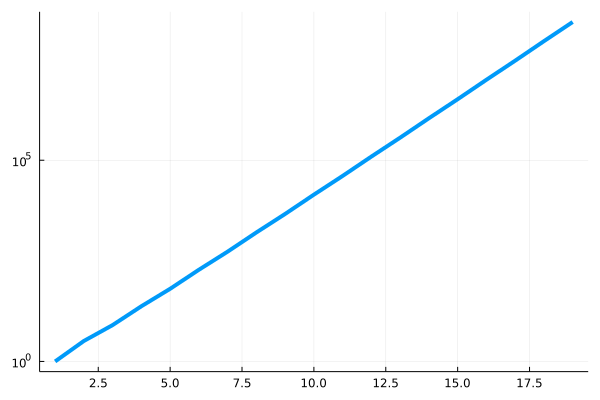

In [22]:
vcond(mat, points, nmax) = [cond(mat(points(-1, 1, n))) for n in 2:nmax]

plot([vcond(vander, LinRange, 20)], yscale=:log10, legend=:none)

## A well-conditioned basis

In [23]:
function vander_legendre(x, k=nothing)
    if isnothing(k)
        k = length(x) # Square by default
    end
    m = length(x)
    Q = ones(m, k)
    Q[:, 2] = x
    for n in 1:k-2
        Q[:, n+2] = ((2*n + 1) * x .* Q[:, n+1] - n * Q[:, n]) / (n + 1)
    end
    Q
end

vander_legendre (generic function with 2 methods)

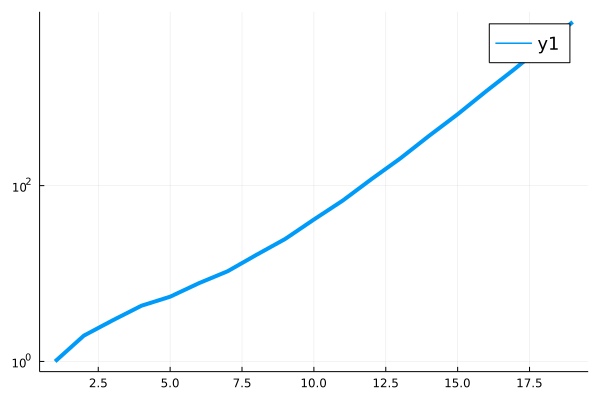

In [24]:
plot([vcond(vander_legendre, LinRange, 20)], yscale=:log10)

## A different set of points

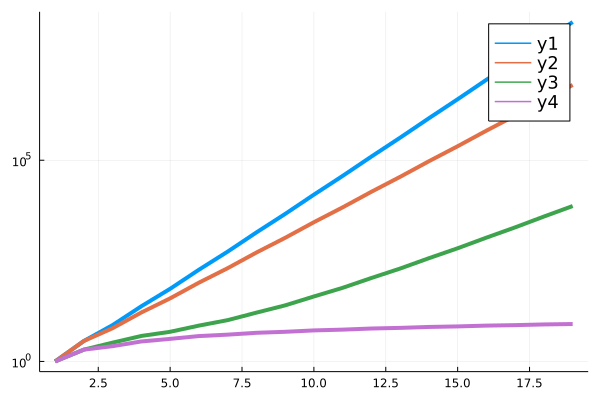

In [25]:
CosRange(a, b, n) = (a + b)/2 .+ (b - a)/2 * cos.(LinRange(-pi, 0, n))

plot([vcond(vander, LinRange, 20)], yscale=:log10)
plot!([vcond(vander, CosRange, 20)], yscale=:log10)
plot!([vcond(vander_legendre, LinRange, 20)], yscale=:log10)
plot!([vcond(vander_legendre, CosRange, 20)], yscale=:log10)

## What's wrong with ill-conditioning?

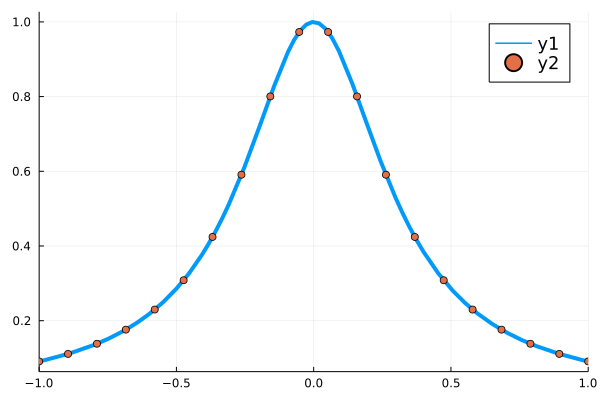

In [61]:
runge1(x) = 1 / (1 + 10*x^2)

x = LinRange(-1, 1, 20)
y = runge1.(x)
plot(runge1, xlims=(-1, 1))
scatter!(x, y)

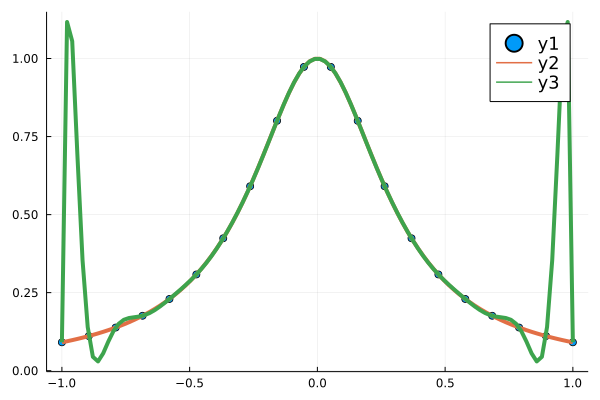

In [62]:
ourvander = vander
p = ourvander(x) \ y;
scatter(x, y)
s = LinRange(-1, 1, 100)
plot!(s, runge1.(s))
plot!(s, ourvander(s, length(x)) * p)

In [64]:
cond(ourvander(s, length(x)) / ourvander(x))

4115.2853049797

In [65]:
cond(ourvander(x))

2.722408230241045e8